# Create a neural network capable of identifying circles
And make it run on a GPU!

In [1]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import random
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import numpy as np
# import fuckit # could not get working in Anaconda - ket hitting other packages
from itertools import product

In [2]:
# Hyperparameters
parameters = dict(
    lr = [0.001],
    batch_size = [25],
    shuffle = [True],
    epochs = [20],
    train_shape = ["circle"] # circle or square are supported
)

param_values = [value for value in parameters.values()]

for lr, batch_size, shuffle, epochs, train_shape in product(*param_values): # Note: * here unpacks a three-tuple of three-tuples into just three three-tuples
    print(lr, batch_size, shuffle, epochs, train_shape)

0.001 25 True 20 circle


In [3]:
IMG_SIZE = 100 # All our circles will be in square this many pixels wide

In [4]:
def draw_circleSlow(x,y,rad,size,mark=1):
    """
    Create a binary 2D matrix representation of a circle
    :param x: x coordinate of circle center
    :param y: y coordinate of circle center
    :param rad: radius of circle
    :param size: size of the matrix (size x size)
    :return: torch matrix (size x size) with 1s representing the circle
    """
    pic = torch.zeros(size,size)
    for i in range(size):
        for j in range(size):
            dx = i-x
            dy = j-y
            d2 = (dx*dx + dy*dy)
            if abs(d2-(rad * rad)) < 10:
                pic[i,j] = mark
            else:
                pic[i,j] = 0
    return pic   

In [5]:
def clip_write(pic,sz,x,y,mark):
    if 0 <= x and x < sz and 0 <= y and y < sz:
        pic[x, y] = mark

# Bresenham circle
# @fuckit
def circ8(pic, xc, yc, x, y,mark=1, sz=100):
    """
    Set 8 symmetric pixels for a circle
    Note: fuckit decorator will silently ignore any excpetions below, most likely caused by a
        poorly trained network attempting to guess a circle that is out of bounds
    """
    clip_write(pic,sz,xc+x, yc+y,mark)
    clip_write(pic,sz,xc-x, yc+y,mark)
    clip_write(pic,sz,xc+x, yc-y,mark)
    clip_write(pic,sz,xc-x, yc-y,mark)
    clip_write(pic,sz,xc+y, yc+x,mark)
    clip_write(pic,sz,xc-y, yc+x,mark)
    clip_write(pic,sz,xc+y, yc-x,mark)
    clip_write(pic,sz,xc-y, yc-x,mark)

def draw_circleFast(xc,yc,radius,size, mark=1):    
    """
    Draw circle using Bresenham algo
    """
    
    # make sure type is float32 pytorch tensor
    pic = torch.zeros(size,size,dtype=torch.float32)
    
    x,y = 0,radius
    err = 3 - 2 * radius
    circ8(pic, xc, yc, x, y, mark)
    while y >= x:    
        x = x + 1
        if err > 0:
            y = y - 1
            err = err + 4 * (x - y) + 10
        else:
            err = err + 4 * x + 6
        circ8(pic, xc, yc, x, y, mark, size)
    return pic

In [6]:
def draw_square(xc, yc, side, size, mark=1):
    """
    Draw square centered at xc,yc, sidelength side
    """
    
    # make sure type is float32 pytorch tensor
    pic = torch.zeros(size,size,dtype=torch.float32)
    
    x1 = xc - side//2 # integer divide
    x2 = x1 + side
    
    y1 = yc - side//2
    y2 = y1 + side
    
    for i in range(x1,x2+1):
        clip_write(pic,size,i,y1,mark)
        clip_write(pic,size,i,y2,mark)
    for j in range(y1,y2+1):
        clip_write(pic,size,x1,j,mark)
        clip_write(pic,size,x2,j,mark)
    return pic    

In [7]:
# Create a 2D representation of a circle, radius 10 at (30,30)
circ30 = draw_circleFast(30, 30, 10, IMG_SIZE)
square30 = draw_square(30, 30, 10, IMG_SIZE)

In [8]:
circ30 # Output of draw_circle is a 2D array of mostly 0s

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

<Figure size 432x288 with 0 Axes>

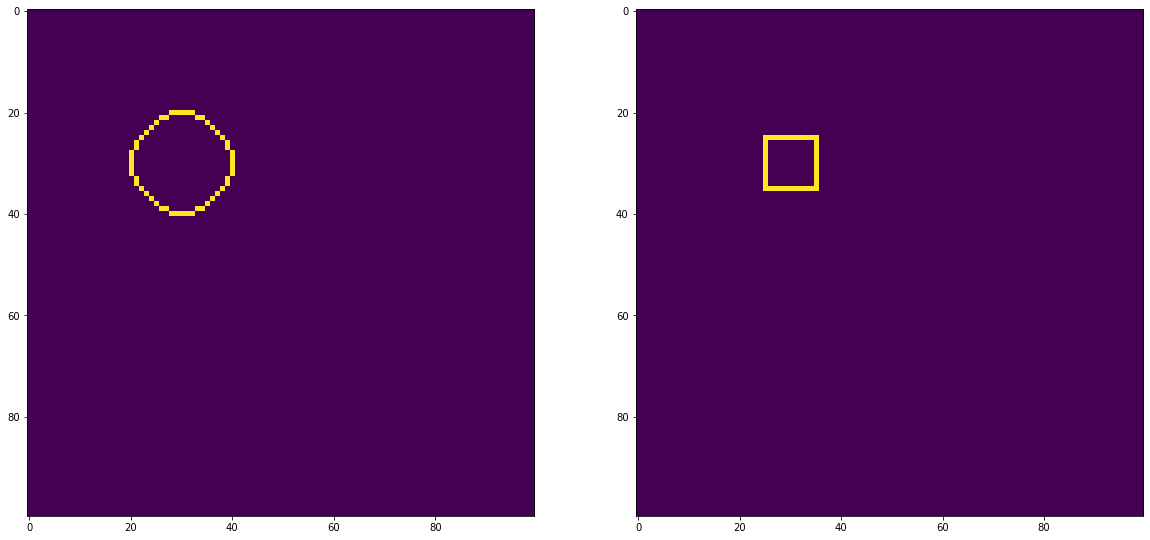

In [9]:
# Plot our square and circle
plt.figure()
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,2,1)
plt.imshow(circ30) # Here's a visual representation of our circle
fig.add_subplot(1,2,2)
plt.imshow(square30)

In [10]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(
                in_channels  = 1,
                padding      = 0,
                out_channels = 32, # may change?
                kernel_size  =  5,  # may change
                stride       =  3
            ),
            # image 100 wide, no padding, kernel 5, stride by 3
            # first is [0,4], 2nd [3,7], 3rd [6,10], ... 32nd [93,97]
            # this in each dim => 32x32 per channel from 100x100 input
            #
            # 32x32 - each channel recognizes a feature
            #
            # 32 channels => 32^3
            #
            nn.BatchNorm2d(32),
            nn.Conv2d(
                in_channels  = 32,
                padding      = 0,
                out_channels = 5, # may change?
                kernel_size  = 9  # may change
            ),
            nn.Flatten(),
            # 5 is out channels, 32 is in size to last conv2d, -8 for kernel size 9
            nn.Linear(5 * (32 - 8) * (32 - 8), 2048),
            nn.ReLU(),
            nn.Linear(2048, 512),
            #nn.Linear(512, 400000), # idiots were here
            #nn.Linear(400000, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
            nn.ReLU()
        )


    def forward(self, our_data):
        x = self.net(our_data)
        return(x)

In [11]:
test_net = NeuralNetwork() # Create an instance of our neural network class, name it "net"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Get the cuda device
print(device)
test_net.to(device)

cuda:0


NeuralNetwork(
  (net): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(32, 5, kernel_size=(9, 9), stride=(1, 1))
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=2880, out_features=2048, bias=True)
    (5): ReLU()
    (6): Linear(in_features=2048, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=3, bias=True)
    (9): ReLU()
  )
)

In [12]:
def mem_used():
    """GB used by CUDA"""
    print("{:.2f} GiB".format(torch.cuda.memory_allocated() / (1024*1024*1024)))

In [13]:
mem_used()

0.03 GiB


In [14]:
# Massage circ30 (a 2D array of mostly 0s and some 1s representing a circle) into something we can use
net_input = circ30.unsqueeze(0).unsqueeze(0)

Note: According to https://stackoverflow.com/a/59566009 Conv2D and many other layers expect input conforming to (n_samples, channels, height, width) # e.g., (1000, 1, 224, 224)

So the two unsqueezes above simply pad the input with 1 sample dimension and 1 channel dimension [100, 100] -> [1, 1, 100, 100]

Also, unsqueeze seems like it's helpful for hacking stuff together early on - it just adds a dimension at the specified index

In [15]:
net_input.shape # Our network input is of shape [1, 1, 100, 100]

torch.Size([1, 1, 100, 100])

In [16]:
ans = test_net(net_input.to(device)) # Run input through the network - No training being done here, just one forward pass

In [17]:
ans.shape # Show the shape of our network output

torch.Size([1, 3])

In [18]:
ans

tensor([[0.0122, 0.0000, 0.0000]], device='cuda:0', grad_fn=<ReluBackward0>)

# Create Training Data for Classifying Circles
### We already have a circle function draw_circle(), so we just need to utilize it to create a bunch of circles matched with their radius and origin
Following https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for the below steps on how to add custom data and datasets and manipulate them via a Dataloader.

### Create a custom dataset to hold our training data
##### Dataset class
torch.utils.data.Dataset is an abstract class representing a dataset. Your custom dataset should inherit Dataset and override the following methods  
* \_\_len__ so that len(dataset) returns the size of the dataset.  
* \_\_getitem__ to support the indexing such that dataset[i] can be used to get iith sample.

In [19]:
class ShapeDataset(Dataset):
    def __init__(self, shapeFunc, num_shapes=10000, param_min=5,param_max=20, size=100):
        randomlist=[] # List of shapes generated somewhat randomly based on position and radius
        truthlist=[] # Cooresponding position and a parameter  for the generated shapes
        for i in range(num_shapes):
            parameter = random.randint(param_min, param_max)
            x = random.randint(parameter,size-parameter-1)
            y = random.randint(parameter,size-parameter-1)
            s = shapeFunc(x,y,parameter,size).unsqueeze(0)
            # Recall tensors fed through our network must have a "channels" dimension, in this case it's one, so we will use unsqueeze again to add it
            # If we had e.g. Red, Green, and Blue data, we would split that into three 100x100 channels
            # "single" is chosen here because it seems to be the only numpy type that plays nice with torch.double that are used throughout the network
            truthlist.append(np.array([x,y,parameter], dtype=np.single))
            randomlist.append(s)
        self.samples = randomlist # Shapes
        self.truth = truthlist # Attributes of those shapes
    def __len__(self):
        return len(self.samples)
    def __getitem__(self,idx):
        sample = {'shape': self.samples[idx], 'attributes': self.truth[idx]}
        return sample

### Using a dataloader allows us to
* Batch the data
* Shuffle the data
* Load the data in parallel using multiprocessing workers.

In [20]:
def check_network(network, verbose=False, draw_func=draw_circleFast):
    radius = random.randint(4, 20)
    x = random.randint(radius,100-radius)
    y = random.randint(radius,100-radius)
    shape = draw_func(x,y,radius,100).unsqueeze(0).unsqueeze(0)
    ans = network(shape.to(device))
    if verbose:
        print("For shape at ({}, {}), r={}, net guessed:\n{}".format(str(x), str(y), str(radius), str(ans)))
    truth = draw_func(x, y, radius, IMG_SIZE, 0.2)
    guess = draw_func(int(ans[0][0]), int(ans[0][1]), int(ans[0][2]), IMG_SIZE)
    return (truth + guess)

In [21]:
def check_network_splatter(network, num_checks=10, writer=None, verbose=False, draw_func=draw_circleFast):
    """
    Given a network and a draw function, call check_network() for the network some number of times
    and plot the results of the check function in a single figure
    """
    plt.figure()
    num_cols = 5
    num_rows = int((num_checks / num_cols) + (1 if (num_checks % num_cols) == 0 else 0))
    fig = plt.figure(figsize=(20,10))#f, canvas = plt.subplots(num_rows, num_cols)
    for check in range(num_checks):
        fig.add_subplot(num_rows, num_cols, check + 1) # + 1 because range is 0-indexed but pyplot is 1-indexed
        plt.imshow(check_network(network, verbose=verbose, draw_func=draw_func))
    # Add this figure to the tensorboard log
    if writer is not None:
        writer.add_figure("Network Splatter", fig)


In [22]:
def train(learning_rate, batch_size, dataset, shuffle=True, epochs=40):
    import time
    
    net = NeuralNetwork().to(device)
    trainloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
        
    # SummaryWriter will store metrics to use with TensorBoard
    comment = f' batch_size={batch_size} lr={lr} shuffle={shuffle} epochs={epochs}'
    writer = SummaryWriter(comment=comment)
            
    #loss_func = nn.functional.cross_entropy # Cross entropy only works for 1D tensors
    #loss_func = nn.L1Loss()
    loss_func = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    
    # initialize empty list to track batch losses
    batch_losses = []
    
    for epoch in range(epochs):
        
        # Reset Iterator
        dataiter = iter(trainloader)
        
        # Keep track of batch number
        batch_number = 0
        
        # Keep track of time 
        last_time = time.time()
        last_epoch = time.time()
        
        # Keep track of per-epoch stats
        epoch_loss = 0
        
        for batch in dataiter:
            batch_number += 1
            
            # Reset Gradients
            optimizer.zero_grad()
            
            # Forward Pass through the network
            out = net(batch["shape"].to(device))
        
            # Calculate loss
            loss = loss_func(out, batch["attributes"].to(device)) # Compare our results with the truth data
            
            # Log the loss for TensorBoard analysis
            # NOTE: we can track loss per batch, as this statement does, or do it per epoch later
            #writer.add_scalar("Loss/train", loss, epoch * len(dataloader) + batch_number)
            
            # track batch loss
            batch_losses.append(loss.item()) # TODO what does batch_losses do?
            epoch_loss += loss.item()
            
            # Backpropagate
            loss.backward()
                
            # Update the parameters
            optimizer.step()
            
            # Time things
            next_time = time.time()
            delta_time = next_time - last_time
            last_time = next_time
            
        # print any stats of the network wrt training progress and loss
        # Time things
        next_epoch = time.time()
        delta_epoch = next_epoch - last_epoch
        last_epoch = next_epoch
        # if ((epoch % 10 == 0) or (epoch % 39 == 0)) and False:
        print("run_id: {}, Epoch: {}, DeltaTime = {:.2f}, LastLoss = {:.2f}".format(
            str(run_id),
            str(epoch), # Epoch
            delta_epoch,
            epoch_loss)) # What is the loss for this batch
        
        # Note, "net" here is our neural network instance.  It looks like this:
        """NeuralNetwork(
          (net): Sequential(
            (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(3, 3))
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): Conv2d(32, 5, kernel_size=(9, 9), stride=(1, 1))
            (3): Flatten(start_dim=1, end_dim=-1)
            (4): Linear(in_features=2880, out_features=2048, bias=True)
            (5): ReLU()
            (6): Linear(in_features=2048, out_features=512, bias=True)
            (7): ReLU()
            (8): Linear(in_features=512, out_features=3, bias=True)
            (9): ReLU()
          )
        )
        """
        # epoch stats
        writer.add_scalar("Loss/train", epoch_loss, epoch)
        for i in range(0,10,2):
           
            writer.add_histogram('conv_{}.bias'.format(i),   net.net[i].bias, epoch)
            writer.add_histogram('conv_{}.weight'.format(i), net.net[i].weight, epoch)
        
        #writer.add_histogram("convA.bias",   net.net[0].bias, epoch)
        #writer.add_histogram("conv1.weight", net.net[0].weight, epoch)
        #writer.add_histogram("conv1.bias",   net.net[0].bias, epoch)
        #writer.add_histogram("conv1.weight", net.net[0].weight, epoch)
        #writer.add_histogram("conv1.bias",   net.net[0].bias, epoch)
        #writer.add_histogram("conv1.weight", net.net[0].weight, epoch)
        #writer.add_histogram("conv1.bias",   net.net[0].bias, epoch)
        #writer.add_histogram("conv1.weight", net.net[0].weight, epoch)
        #writer.add_histogram("conv2.bias",   net.net[0].bias, epoch)
        #writer.add_histogram("conv2.weight", net.net[0].weight, epoch)
               
    # See how the network did.
    check_network_splatter(net, writer=writer)
    writer.close()
    return net

Creating dataset for shape circle with 10000 samples
Training network with LR=0.001 BATCH=25, SHUFFLE=True, EPOCHS=20
run_id: 0, Epoch: 0, DeltaTime = 2.05, LastLoss = 24630.77
run_id: 0, Epoch: 1, DeltaTime = 1.68, LastLoss = 3867.54
run_id: 0, Epoch: 2, DeltaTime = 1.60, LastLoss = 3353.20
run_id: 0, Epoch: 3, DeltaTime = 1.62, LastLoss = 2613.10
run_id: 0, Epoch: 4, DeltaTime = 1.85, LastLoss = 2581.59
run_id: 0, Epoch: 5, DeltaTime = 2.01, LastLoss = 3240.73
run_id: 0, Epoch: 6, DeltaTime = 2.11, LastLoss = 2022.49
run_id: 0, Epoch: 7, DeltaTime = 1.85, LastLoss = 1545.18
run_id: 0, Epoch: 8, DeltaTime = 1.90, LastLoss = 1451.68
run_id: 0, Epoch: 9, DeltaTime = 2.14, LastLoss = 1404.24
run_id: 0, Epoch: 10, DeltaTime = 1.86, LastLoss = 1643.26
run_id: 0, Epoch: 11, DeltaTime = 1.86, LastLoss = 1273.90
run_id: 0, Epoch: 12, DeltaTime = 1.66, LastLoss = 1395.02
run_id: 0, Epoch: 13, DeltaTime = 1.77, LastLoss = 1755.44
run_id: 0, Epoch: 14, DeltaTime = 1.81, LastLoss = 1227.91
run_id

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

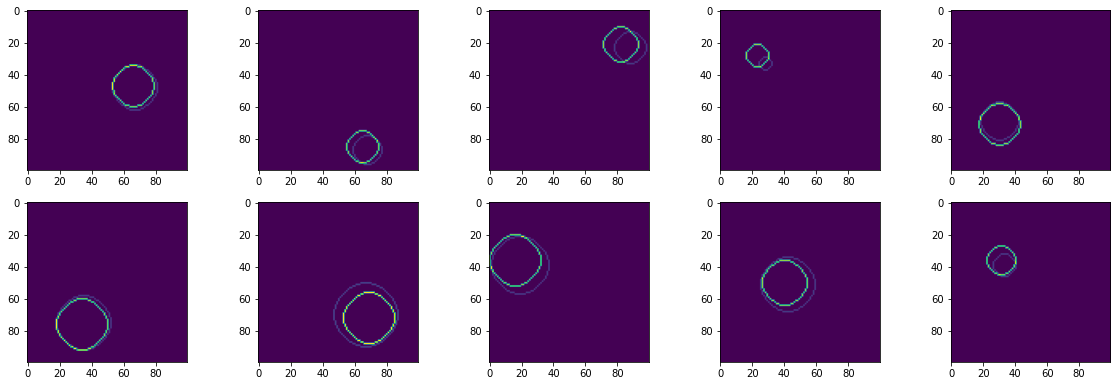

In [26]:
for run_id, (lr, batch_size, shuffle, epochs, train_shape) in enumerate(product(*param_values)):
    dataset_size = 10000 # Should this be a hyperparameter?
    print("Creating dataset for shape {} with {} samples".format(train_shape, dataset_size))
    draw_funcs = (draw_square,draw_circleFast) if (train_shape == "square") else (draw_circleFast,draw_square)
    dataset1 = ShapeDataset(draw_funcs[0], dataset_size)
    
    print("Training network with LR={} BATCH={}, SHUFFLE={}, EPOCHS={}".format(lr, batch_size, str(shuffle), epochs))
    netout = train(lr, batch_size, dataset1, shuffle, epochs)
    
    # dataset2 = ShapeDataset(draw_funcs[1], dataset_size)
    
    check_network_splatter(netout, num_checks=10, draw_func=draw_funcs[0], verbose=True)

In [24]:
mem_used()

0.08 GiB


In [25]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |   81959 KB |  182458 KB |     840 GB |     840 GB |
|       from large pool |   81408 KB |  181760 KB |     819 GB |     819 GB |
|       from small pool |     551 KB |    2610 KB |      21 GB |      21 GB |
|---------------------------------------------------------------------------|
| Active memory         |   81959 KB |  182458 KB |     840 GB |     840 GB |
|       from large pool |   81408 KB |  181760 KB |     819 GB |

Run this command from the dirctory containing "logdir" to stand up tensorboard log viewer
```sh
tensorboard --logdir=runs
```
Then go to http://localhost:6006/